In [212]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from ar_calculation import calculate_rotmat
import toml
from picamera2 import Picamera2
from libcamera import controls
from cv2 import aruco

In [213]:
ARUCO_PARAMETERS = aruco.DetectorParameters()
ARUCO_DICT = aruco.getPredefinedDictionary(aruco.DICT_ARUCO_ORIGINAL)
detector = aruco.ArucoDetector(ARUCO_DICT, ARUCO_PARAMETERS)
markerLength = 0.05
markerSeperation = 0.01

default_ids = [12, 88, 89]

board = aruco.GridBoard(
    size=[1, 1],
    markerLength=markerLength,
    markerSeparation=markerSeperation,
    dictionary=ARUCO_DICT,
)

In [214]:
data = toml.load("../settings2.toml")
camera_matrix = np.array(data["calibration"]["camera_matrix"]).reshape(3, 3)
dist_coeff = np.array(data["calibration"]["dist_coeffs"])


_parent_dir = os.path.join(os.path.dirname(os.getcwd()), "data")
_folder_name = "random_re_0"
_base_pth = os.path.join(_parent_dir, "recordings", _folder_name)

In [215]:
picam2 = Picamera2()
# main = {'size': (800, 480)}
main = {"size": (1536, 864)}
_c = {"FrameRate": 100, "AfMode": controls.AfModeEnum.Manual, "LensPosition": 0.4}
config = picam2.create_video_configuration(main, controls=_c)
picam2.configure(config)
picam2.start()

_frame = picam2.capture_array()


_frame = cv2.cvtColor(_frame, cv2.COLOR_RGBA2GRAY)
meta = picam2.capture_metadata()

[2:05:07.643348952] [3131]  INFO Camera camera_manager.cpp:284 libcamera v0.2.0+120-eb00c13d
[2:05:07.658066179] [4746]  INFO RPI pisp.cpp:695 libpisp version v1.0.5 999da5acb4f4 17-04-2024 (14:29:29)
[2:05:07.673194777] [4746]  INFO RPI pisp.cpp:1154 Registered camera /base/axi/pcie@120000/rp1/i2c@88000/imx708@1a to CFE device /dev/media2 and ISP device /dev/media0 using PiSP variant BCM2712_C0
[2:05:07.678587495] [3131]  INFO Camera camera_manager.cpp:284 libcamera v0.2.0+120-eb00c13d
[2:05:07.698071014] [4749]  INFO RPI pisp.cpp:695 libpisp version v1.0.5 999da5acb4f4 17-04-2024 (14:29:29)
[2:05:07.722379733] [4749]  INFO RPI pisp.cpp:1154 Registered camera /base/axi/pcie@120000/rp1/i2c@88000/imx708@1a to CFE device /dev/media2 and ISP device /dev/media0 using PiSP variant BCM2712_C0
[2:05:07.737678979] [3131]  WARN V4L2 v4l2_pixelformat.cpp:344 Unsupported V4L2 pixel format RPBP
[2:05:07.738773571] [3131]  INFO Camera camera.cpp:1183 configuring streams: (0) 1536x864-XBGR8888 (1) 1

In [216]:
# meta = picam2.capture_metadata()
print(meta["LensPosition"])

0.4000000059604645


In [217]:
picam2.camera_controls["LensPosition"]

(0.0, 32.0, 1.0)

In [218]:
picam2.close()

In [219]:
_frame.shape

(864, 1536)

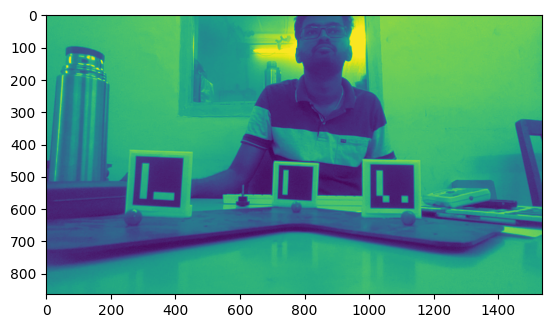

In [220]:
plt.imshow(_frame)

In [221]:
# asdf

In [222]:
def estimate_pose_single_markers(
    corners, marker_size, camera_matrix, distortion_coefficients
):
    marker_points = np.array(
        [
            [-marker_size / 2, marker_size / 2, 0],
            [marker_size / 2, marker_size / 2, 0],
            [marker_size / 2, -marker_size / 2, 0],
            [-marker_size / 2, -marker_size / 2, 0],
        ],
        dtype=np.float32,
    )
    rvecs = []
    tvecs = []
    for corner in corners:
        _, r, t = cv2.solvePnP(
            marker_points,
            corner,
            camera_matrix,
            distortion_coefficients,
            True,
            flags=cv2.SOLVEPNP_IPPE_SQUARE,
        )
        if r is not None and t is not None:
            r = np.array(r).reshape(1, 3).tolist()
            t = np.array(t).reshape(1, 3).tolist()
            rvecs.append(r)
            tvecs.append(t)
    return np.array(rvecs, dtype=np.float32), np.array(tvecs, dtype=np.float32)

In [223]:
corners, ids, rejected_points = detector.detectMarkers(_frame)

rotation_vector, translation_vector = estimate_pose_single_markers(
    corners, 0.05, camera_matrix, dist_coeff
)

ids = list(ids)

z_inx = ids.index(1)
org_inx = ids.index(0)
x_inx = ids.index(2)

zvec = translation_vector[z_inx][0].reshape(3, 1)
org = translation_vector[org_inx][0].reshape(3, 1)
xvec = translation_vector[x_inx][0].reshape(3, 1)

rotMat = calculate_rotmat(xvec, zvec, org)

t_zvec = zvec - org
t_xvec = xvec - org

translation_correction = np.array([0.04, -0.0, 0.0]).reshape(
    3, 1
)  # adding the corrections in the new L frame

rotMat.T @ t_zvec + translation_correction
print((rotMat.T @ t_xvec).T[0])
print((rotMat.T @ t_zvec).T[0])

[ 1.5231156e-01 -6.9241324e-10 -5.2895075e-09]
[ 5.8988035e-02 -1.2025794e-09  2.5186539e-01]


In [224]:
meta

{'AeLocked': False,
 'ColourGains': (1.9519771337509155, 2.0550880432128906),
 'ColourTemperature': 3770,
 'ExposureTime': 9540,
 'ScalerCrop': (768, 432, 3072, 1728),
 'FrameDuration': 9991,
 'SensorTemperature': 35.0,
 'SensorTimestamp': 7507957806000,
 'AnalogueGain': 5.657458782196045,
 'LensPosition': 0.4000000059604645,
 'AfPauseState': 0,
 'SensorBlackLevels': (4096, 4096, 4096, 4096),
 'Lux': 516.0748901367188,
 'DigitalGain': 1.044979214668274,
 'AfState': 0,
 'ColourCorrectionMatrix': (1.607796311378479,
  -0.4160536229610443,
  -0.19174937903881073,
  -0.36791571974754333,
  1.7545669078826904,
  -0.38665279746055603,
  0.005174868740141392,
  -0.5874773263931274,
  1.5823124647140503),
 'FocusFoM': 140}

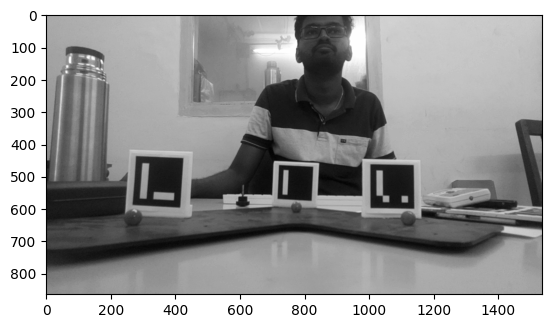

In [225]:
plt.imshow(_frame, cmap="grey")